In [1]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
from skimage.filters import median
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening
from skimage.exposure import histogram

In [17]:
def adjust_rotation(image):
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(image > 0))
    
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle

    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_AREA     , borderMode=cv2.BORDER_REPLICATE)

    return rotated


In [3]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [4]:
# binarize the image withe the best between the regular threshold mean and the otsu threshold value
def binarizeImage(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return gray

In [104]:
# remove elements from array that are close to each other with the (cozy value as the var of diiference)
def closer(arr,cozy):
    result = []
    result.append(arr[0])
    for i in range(1,len(arr)-1):
        if arr[i]-result[-1]>cozy:
            result.append(arr[i])
    return result  

#  segment lines and plot the line histogram
def lineSegmenter(img,plot):
    rows=np.sum(img,1)
    y_pos = np.arange(len(rows))
    peaks=np.logical_and(rows>10, rows<1000)
    peaks=y_pos[peaks]
    peaks=closer(peaks,4)

    lines=[]
    for i in range(len(peaks)):
        if(i==len(peaks)-1):
            continue
        lines.append(img[peaks[i]:peaks[i+1],:])

    if(plot==True):
        plt.barh(y_pos, rows, align='center', alpha=0.5)
        plt.xlabel('Sum of pixels')
        plt.title('Row Contribution')
        plt.show()

    return lines

def wordSegmenter(line):
    words=[]
    for i in line:
        peaks=[]
        print(i.shape)
        for x in range(i.shape[1]):
            value=0
            for y in range(i.shape[0]):
                value+=i[y,x]
            if(value>3):
                peaks.append(x)
        peaks=closer(peaks,3)

        for z in range(len(peaks)):
            if(z==len(peaks)-1):
                continue
            words.append(i[:,peaks[z]:peaks[z+1]]) 
    
    return words



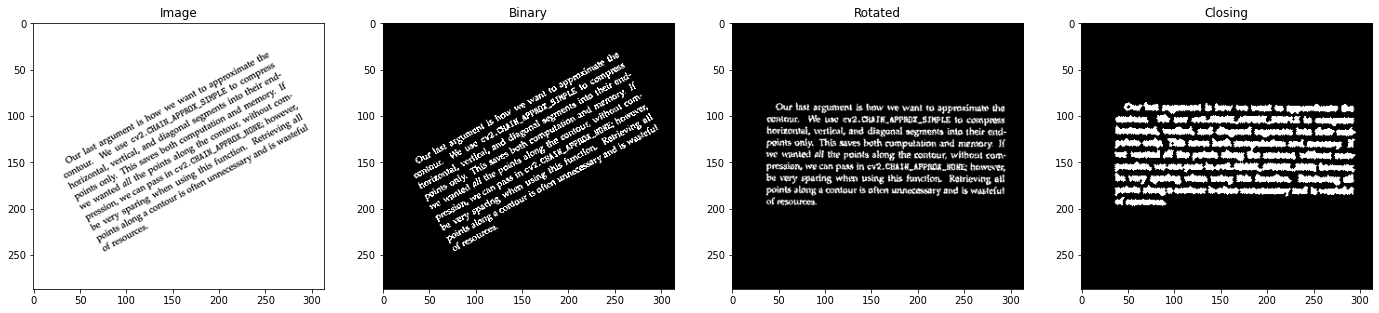

(314,)


IndexError: tuple index out of range

In [105]:
# load the image from disk
image = cv2.imread('f3.png')

# ski_median=skimage.filters.median(image, selem=None, out=None, mode='nearest', cval=0.15, behavior='ndimage')

# rotated image need a binary image
binary= binarizeImage(image)

# check if the image is rotated or not and adjust rotation
rotated=adjust_rotation(binary)
 
# apply closing to link the alphabets of the same word together to begin word segmentation
closing=binary_closing(rotated)

# get copy of the image
copy=rotated.copy()

show_images([image,binary,rotated,closing],['Image','Binary','Rotated','Closing'])

# extract lines from the image and insert them in lines array
lines=lineSegmenter(copy,False)

# printing the lines
# for i in lines:
#     show_images([i])

words=wordSegmenter(lines[0])  

# printing the word
for i in words:
    show_images([i])


